<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula10a_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p datasets
!mkdir -p datasets/bitcoin

In [2]:
!wget https://gist.githubusercontent.com/Dudu197/a9a38c424fd41f82dc27ff34d8ee170f/raw/79927733065e72bbe8ab4d0a7255855e79584ae4/coin_prices.csv -P datasets/bitcoin

--2024-05-19 15:20:02--  https://gist.githubusercontent.com/Dudu197/a9a38c424fd41f82dc27ff34d8ee170f/raw/79927733065e72bbe8ab4d0a7255855e79584ae4/coin_prices.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8883805 (8.5M) [text/plain]
Saving to: ‘datasets/bitcoin/coin_prices.csv’

coin_prices.csv     100%[===================>]   8.47M  16.5MB/s    in 0.5s    

2024-05-19 15:20:04 (16.5 MB/s) - ‘datasets/bitcoin/coin_prices.csv’ saved [8883805/8883805]



In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

2024-05-21 18:39:10.466497: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 18:39:10.707568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 18:39:11.337864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("datasets/bitcoin/coin_prices.csv")

In [3]:
df = df[df["coin"] == "BTC"]

In [4]:
df

,Unnamed: 0,date,coin,volume,price
53,53,2021-05-13,BTC,7.852778e+10,47884.917106
154,154,2021-05-14,BTC,9.149487e+10,49997.846250
253,253,2021-05-15,BTC,5.551275e+10,50189.527235
353,353,2021-05-16,BTC,5.997922e+10,47480.816852
453,453,2021-05-17,BTC,6.306813e+10,46211.384370
...,...,...,...,...,...
90954,90954,2023-11-09,BTC,1.751828e+10,35661.036826
91054,91054,2023-11-10,BTC,3.753632e+10,36680.129620
91155,91155,2023-11-11,BTC,2.254243e+10,37338.914097
91254,91254,2023-11-12,BTC,1.390765e+10,37135.295578


<Axes: >

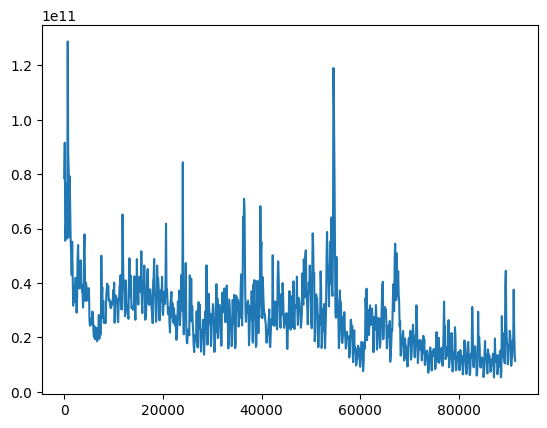

In [5]:
df["volume"].plot()

<Axes: >

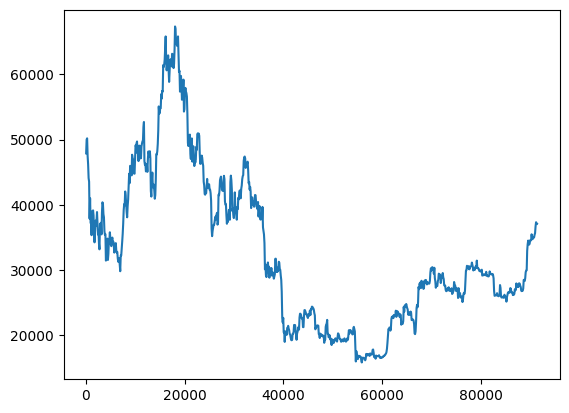

In [6]:
df["price"].plot()

In [7]:
num_train_samples = int(0.5 * len(df))
num_val_samples = int(0.25 * len(df))
num_test_samples = len(df) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(457, 228, 229)

In [8]:
price_mean = df.iloc[:num_train_samples]["price"].mean(axis=0)
df["price"] -= price_mean
price_std = df.iloc[:num_train_samples]["price"].std(axis=0)
df["price"] /= price_std

In [9]:
volume_mean = df.iloc[:num_train_samples]["volume"].mean(axis=0)
df["volume"] -= price_mean
volume_std = df.iloc[:num_train_samples]["volume"].std(axis=0)
df["volume"] /= price_std

In [11]:
prices = df["price"].values
prices = np.concatenate([prices[1:], [prices[-1]]])
df["next_price"] = prices

In [13]:
df.iloc[:10]

,Unnamed: 0,date,coin,volume,price,next_price
53,53,2021-05-13,BTC,7.005383e+06,0.660899,0.849392
154,154,2021-05-14,BTC,8.162164e+06,0.849392,0.866491
253,253,2021-05-15,BTC,4.952234e+06,0.866491,0.624850
353,353,2021-05-16,BTC,5.350683e+06,0.624850,0.511605
453,453,2021-05-17,BTC,5.626243e+06,0.511605,0.323549
553,553,2021-05-18,BTC,6.826660e+06,0.323549,0.273839
653,653,2021-05-19,BTC,5.025796e+06,0.273839,-0.231399
753,753,2021-05-20,BTC,1.147877e+07,-0.231399,0.046625
853,853,2021-05-21,BTC,7.843685e+06,0.046625,-0.290847
953,953,2021-05-22,BTC,7.257266e+06,-0.290847,-0.289780


In [14]:
num_train_samples

457

In [15]:
len(df)

914

In [16]:
sampling_rate = 6
sequence_length = 7
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    data = df.iloc[:num_train_samples]["price"].values,
    targets = df.iloc[:num_train_samples]["next_price"].values,
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size)

val_index = num_train_samples + num_val_samples
val_dataset = keras.utils.timeseries_dataset_from_array(
    data = df.iloc[num_train_samples:val_index]["price"].values,
    targets = df.iloc[num_train_samples:val_index]["next_price"].values,
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size)

test_index = val_index + num_test_samples
test_dataset = keras.utils.timeseries_dataset_from_array(
    data = df.iloc[val_index:]["price"].values,
    targets = df.iloc[val_index:]["next_price"].values,
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size)

2024-05-21 18:41:08.623929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 18:41:08.732884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 18:41:08.733068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 18:41:08.735641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 18:41:08.735801: I tensorflow/compile

In [17]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (256, 7)
targets shape (256,)


# baseline

In [19]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.23
Test MAE: 0.26


# densely conected

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("btc_dense.model",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("btc_dense.model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2024-05-21 18:41:42.444043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-21 18:41:42.497086: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2bde0b7d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 18:41:42.497114: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-05-21 18:41:42.523547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 18:41:42.613578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-21 18:41:42.839662: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-05-21 18:41:42.944542: I ./t

1/2 [==============>...............] - ETA: 0s - loss: 1.0655 - mae: 0.7024INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 1s 404ms/step - loss: 0.9837 - mae: 0.6641 - val_loss: 0.2199 - val_mae: 0.4572
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.8777 - mae: 0.6257INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 225ms/step - loss: 0.8504 - mae: 0.6253 - val_loss: 0.1561 - val_mae: 0.3822
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.7518 - mae: 0.5922INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 279ms/step - loss: 0.7692 - mae: 0.5985 - val_loss: 0.1203 - val_mae: 0.3327
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6803 - mae: 0.5667INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 209ms/step - loss: 0.7059 - mae: 0.5779 - val_loss: 0.0971 - val_mae: 0.2963
Epoch 5/10
1/2 [==============>...............] - ETA: 0s - loss: 0.5585 - mae: 0.5147INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 197ms/step - loss: 0.6538 - mae: 0.5597 - val_loss: 0.0768 - val_mae: 0.2606
Epoch 6/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6763 - mae: 0.5720INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 205ms/step - loss: 0.6097 - mae: 0.5432 - val_loss: 0.0640 - val_mae: 0.2358
Epoch 7/10
1/2 [==============>...............] - ETA: 0s - loss: 0.4570 - mae: 0.4782INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 201ms/step - loss: 0.5721 - mae: 0.5297 - val_loss: 0.0542 - val_mae: 0.2148
Epoch 8/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6013 - mae: 0.5443INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 194ms/step - loss: 0.5368 - mae: 0.5162 - val_loss: 0.0494 - val_mae: 0.2042
Epoch 9/10
1/2 [==============>...............] - ETA: 0s - loss: 0.4403 - mae: 0.4726INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


2/2 [==============================] - 0s 197ms/step - loss: 0.5068 - mae: 0.5042 - val_loss: 0.0441 - val_mae: 0.1915
Epoch 10/10
1/2 [==============>...............] - ETA: 0s - loss: 0.5025 - mae: 0.5142INFO:tensorflow:Assets written to: btc_dense.model/assets


INFO:tensorflow:Assets written to: btc_dense.model/assets


1/1 [==============================] - 0s 68ms/step - loss: 0.0222 - mae: 0.1308
Test MAE: 0.13


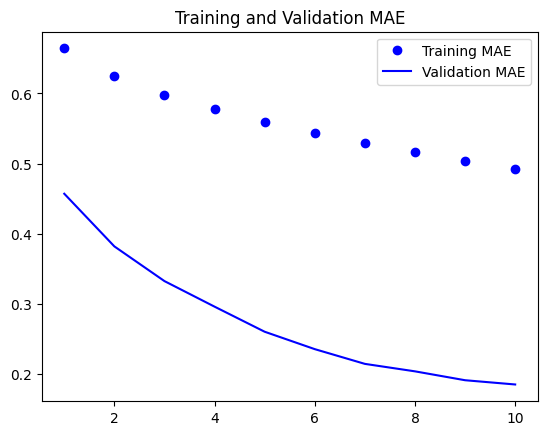

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

# LSTM

In [30]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(64)(inputs)
x = layers.Dense(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("btc_lstm.model",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("btc_lstm.model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1/2 [==============>...............] - ETA: 0s - loss: 0.9728 - mae: 0.7728INFO:tensorflow:Assets written to: btc_lstm.model/assets


INFO:tensorflow:Assets written to: btc_lstm.model/assets


2/2 [==============================] - 1s 287ms/step - loss: 0.9133 - mae: 0.7386 - val_loss: 2.6822 - val_mae: 1.6230
Epoch 2/10
2/2 [==============================] - 0s 48ms/step - loss: 0.8726 - mae: 0.7204 - val_loss: 3.0789 - val_mae: 1.7412
Epoch 3/10
2/2 [==============================] - 0s 42ms/step - loss: 0.8587 - mae: 0.7134 - val_loss: 3.3912 - val_mae: 1.8287
Epoch 4/10
2/2 [==============================] - 0s 39ms/step - loss: 0.8520 - mae: 0.7105 - val_loss: 3.6103 - val_mae: 1.8877
Epoch 5/10
2/2 [==============================] - 0s 46ms/step - loss: 0.8492 - mae: 0.7098 - val_loss: 3.7620 - val_mae: 1.9275
Epoch 6/10
2/2 [==============================] - 0s 47ms/step - loss: 0.8481 - mae: 0.7093 - val_loss: 3.8487 - val_mae: 1.9499
Epoch 7/10
2/2 [==============================] - 0s 38ms/step - loss: 0.8475 - mae: 0.7089 - val_loss: 3.9342 - val_mae: 1.9717
Epoch 8/10
2/2 [==============================] - 0s 38ms/step - loss: 0.8473 - mae: 0.7092 - val_loss: 3.9

# dropout-regularized LSTM

In [31]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("btc_lstm_dropout.model",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("btc_lstm_dropout.model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1/2 [==============>...............] - ETA: 0s - loss: 0.7242 - mae: 0.6533INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 2s 966ms/step - loss: 0.5973 - mae: 0.5844 - val_loss: 1.7249 - val_mae: 1.3000
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.3994 - mae: 0.4808INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 984ms/step - loss: 0.4449 - mae: 0.5161 - val_loss: 1.3012 - val_mae: 1.1265
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.4046 - mae: 0.4945INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 843ms/step - loss: 0.3763 - mae: 0.4752 - val_loss: 0.9291 - val_mae: 0.9481
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 0.3351 - mae: 0.4433INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 838ms/step - loss: 0.3517 - mae: 0.4607 - val_loss: 0.6697 - val_mae: 0.8006
Epoch 5/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2712 - mae: 0.4157INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 862ms/step - loss: 0.3032 - mae: 0.4403 - val_loss: 0.4950 - val_mae: 0.6834
Epoch 6/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2812 - mae: 0.4192INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 1s/step - loss: 0.2592 - mae: 0.4022 - val_loss: 0.3922 - val_mae: 0.6042
Epoch 7/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2885 - mae: 0.4322INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 866ms/step - loss: 0.2939 - mae: 0.4290 - val_loss: 0.3073 - val_mae: 0.5298
Epoch 8/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2600 - mae: 0.4006INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 872ms/step - loss: 0.2482 - mae: 0.3915 - val_loss: 0.2838 - val_mae: 0.5074
Epoch 9/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2772 - mae: 0.4167INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


INFO:tensorflow:Assets written to: btc_lstm_dropout.model/assets


2/2 [==============================] - 1s 998ms/step - loss: 0.2582 - mae: 0.3974 - val_loss: 0.2524 - val_mae: 0.4758
Epoch 10/10
2/2 [==============================] - 0s 60ms/step - loss: 0.2376 - mae: 0.3862 - val_loss: 0.2786 - val_mae: 0.5027


1/1 [==============================] - 0s 127ms/step - loss: 0.0705 - mae: 0.2190
Test MAE: 0.22


# bidirectional LSTM

In [32]:
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
x = layers.Dense(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("btc_lstm_bidirectional.model",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("btc_lstm_bidirectional.model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1/2 [==============>...............] - ETA: 1s - loss: 1.0585 - mae: 0.7816INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 5s 4s/step - loss: 0.9847 - mae: 0.7609 - val_loss: 3.5028 - val_mae: 1.8582
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.7983 - mae: 0.6946INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.7339 - mae: 0.6602 - val_loss: 2.8824 - val_mae: 1.6842
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6439 - mae: 0.6267INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.5940 - mae: 0.5968 - val_loss: 2.3597 - val_mae: 1.5221
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 0.5563 - mae: 0.5905INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.4941 - mae: 0.5481 - val_loss: 1.9269 - val_mae: 1.3734
Epoch 5/10
1/2 [==============>...............] - ETA: 0s - loss: 0.4201 - mae: 0.5134INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.4164 - mae: 0.5083 - val_loss: 1.5521 - val_mae: 1.2303
Epoch 6/10
1/2 [==============>...............] - ETA: 0s - loss: 0.3730 - mae: 0.4899INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.3563 - mae: 0.4751 - val_loss: 1.2299 - val_mae: 1.0923
Epoch 7/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2973 - mae: 0.4333INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.3126 - mae: 0.4475 - val_loss: 1.0001 - val_mae: 0.9822
Epoch 8/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2792 - mae: 0.4203INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.2800 - mae: 0.4255 - val_loss: 0.7861 - val_mae: 0.8670
Epoch 9/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2455 - mae: 0.3952INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


2/2 [==============================] - 3s 3s/step - loss: 0.2583 - mae: 0.4096 - val_loss: 0.6152 - val_mae: 0.7628
Epoch 10/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2557 - mae: 0.4066INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


INFO:tensorflow:Assets written to: btc_lstm_bidirectional.model/assets


1/1 [==============================] - 0s 268ms/step - loss: 0.1266 - mae: 0.3152
Test MAE: 0.32
